In [5]:
from collections import defaultdict
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

## Environment Encoding

We'll encode the CSV with the following states.
- 0 is on the track.
- 1 is out of bounds.
- 2 is finish line.
- 3 is starting line.

In [6]:

class Environment():
    ACTIONS = {
        0 : (1, -1),
        1 : (1, 0),
        2 : (1, 1),
        3 : (0, -1),
        4 : (0, 0),
        5 : (0, 1),
        6 : (-1, -1),
        7 : (-1, 0),
        8 : (-1, 1)
    }

    ACTION_SPACE = len(ACTIONS)

    def __init__(self, path: str) -> None:
        self.racetrack: npt.NDArray = np.loadtxt(path, delimiter=",")
        self.starts: npt.NDArray = np.argwhere(self.racetrack == 3)
        self.ends: npt.NDArray = np.argwhere(self.racetrack == 2)
        self.reset()

    def get_actions(self):
        return [*self.ACTIONS]

    def reset(self) -> None:
        self.state: npt.NDArray = self.starts[np.random.choice(self.starts.shape[0]), :].copy()
        self.velocity: npt.NDArray = np.zeros(2, dtype=np.int32)

    def step(self, action: int, randomness: int = 0.1) -> Tuple[npt.NDArray, npt.NDArray, bool]:
        done = False
        reward = -1

        # Don't change velocity with some randomness.
        if np.random.rand() >= randomness:
            self.velocity += self.ACTIONS[action]
        self.state += self.velocity

        # Constrain to within racetrack array.
        self.state.clip(0, np.array(self.racetrack.shape) - 1, out=self.state)

        # State checks. Ignore starting state as it's only used for initialization.
        if self.racetrack[tuple(self.state)] == 1:
            reward -= 10
            self.reset()
        elif self.racetrack[tuple(self.state)] == 2:
            reward += 10
            done = True

        return self.state, reward, done

In [ ]:
class Agent():
    def __init__(self, env: Environment, num_iterations: int = 1000, epsilon: float = 0.1, gamma: float = 0.9, alpha: float = 0.2) -> None:
        self.env: Environment = env
        self.num_iterations: int = num_iterations
        self.epsilon: float = epsilon
        self.gamma: float = gamma
        self.alpha: float = alpha

        shape = (*self.env.racetrack.shape, len(self.env.get_actions()))
        self.Q: npt.NDArray = np.zeros(shape)
        self.rewards: list = []
        self.policy: npt.NDArray = (1 / self.env.ACTION_SPACE) * np.ones(shape)
        self.returns: npt.NDArray = np.zeros(shape)

    def print_action(self):
        for i in range(self.env.racetrack.shape[0]):
            line = "|"
            for j in range(self.env.racetrack.shape[1]):
                action = np.argmax(self.Q[(i, j)])
                line += f"{action:02}, {action:02}|"
            print(f"{line}")

    def simulate_Q(self) -> None:
        episode = self.generate_episode()
        for state, action, _ in episode:
            print(f"Position: {state[1] + 1}, {state[0] + 1} | Action: {action}")

    def plot_rewards(self) -> None:
        plt.plot(range(len(self.rewards)), self.rewards)
        plt.title("On Policy - Sarsa Control")
        plt.xlabel("Episode")
        plt.ylabel("Undiscounted Return")     

    def generate_episode(self) -> list:
        episode = []
        self.env.reset()

        done = False
        while not done:
            state = self.env.state.copy()
            probabilities = self.policy[tuple(state)]
            probabilities = probabilities / np.sum(probabilities)
            action = np.argmax(probabilities)
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
        
        return episode

    def sarsa(self) -> None:
        for i in range(self.num_iterations):
            self.env.reset()

            state = tuple(self.env.state)
            probabilities = self.policy[state]
            probabilities = probabilities / np.sum(probabilities)
            action = (np.random.choice(self.env.ACTION_SPACE, p=probabilities),)

            done = False
            self.rewards.append(0)
            while not done:
                next_state, reward, done = self.env.step(*action)
                next_state = tuple(next_state)
                self.rewards[-1] += reward 

                probabilities = self.policy[next_state]
                probabilities = probabilities / np.sum(probabilities)
                next_action = (np.random.choice(self.env.ACTION_SPACE, p=probabilities),)

                self.Q[state + action] = self.Q[state + action] + (self.alpha * ((reward + self.gamma * self.Q[next_state + next_action]) - self.Q[state + action]))

                optimal_action = np.argmax(self.Q[state])
                for a in self.env.get_actions():
                    if (a == optimal_action).all():
                        self.policy[state, a] = 1 - self.epsilon + (self.epsilon / self.env.ACTION_SPACE)
                    else:
                        self.policy[state, a] = self.epsilon / self.env.ACTION_SPACE

                state = next_state
                action = next_action
            
            print(i, self.rewards[-1])

0 -2482
1 -2417
2 -2175
3 -5813
4 -1422
5 -7592
6 -486
7 -3885
8 -4570
9 -2136
10 -7365
11 -8302
12 -1170
13 -6053
14 -2254
15 -6683
16 -8229
17 -5287
18 -677
19 -1639
20 -7231
21 -7101
22 -7060
23 -2481
24 -2095
25 -410
26 -2776
27 -76
28 -2914
29 -1461
30 -1269
31 -2347
32 -3657
33 -804
34 -15804
35 -7160
36 -6939
37 -247
38 -2398
39 -3034
40 -10312
41 -5348
42 -3197
43 -10767
44 -2054
45 -2627
46 -4390
47 -4263
48 -8559
49 -228
50 -8065
51 -3794
52 -7368
53 -5097
54 -7204
55 -6874
56 -5351
57 -4903
58 -1653
59 -3090
60 -3201
61 -13615
62 -8899
63 -626
64 -2979
65 -231
66 -5947
67 -1221
68 -1453
69 -5537
70 -1982
71 -2936
72 -1502
73 -18911
74 -548
75 -5354
76 -1419
77 -3706
78 -9221
79 -389
80 -2862
81 -6733
82 -15152
83 -4745
84 -2926
85 -1425
86 -1259
87 -361
88 -1381
89 -6776
90 -8257
91 -540
92 -2006
93 -242
94 -622
95 -7062
96 -2224
97 -12654
98 -1315
99 -169
100 -13844
101 -12878
102 -13155
103 -2058
104 -19478
105 -596
106 -3844
107 -9714
108 -4159
109 -1380
110 -1268
111 -69

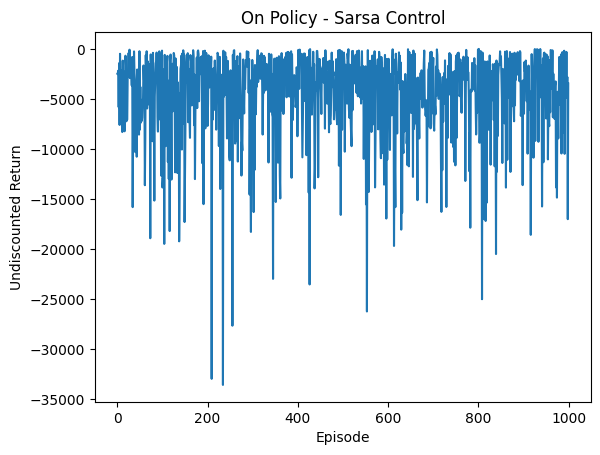

In [19]:
env = Environment("./racetrack2.csv")
agent = Agent(env)
agent.sarsa()
agent.print_action()
agent.plot_rewards()